# Dashboard - SIR Model

## Name: Rohit Dev

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go

from datetime import datetime

In [2]:
%matplotlib inline
sns.set(style='darkgrid')
mpl.rcParams['figure.figsize'] = (16,9)
pd.set_option('display.max_rows', 500)

In [3]:
# SIR Model is being for shown 3 countries
country_list = ['Germany', 'India', 'Spain']

In [4]:
# Import raw data
raw_data=pd.read_csv('../data/raw/owid-covid-data.csv')

In [5]:
# display raw data
raw_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [6]:
# raw_data columns list
raw_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [7]:
# Sorting of required data from raw data  
data_sort = raw_data[['date', 'location','total_cases', 'population']]

In [8]:
# Changing column names
data_sort = data_sort.rename(columns={'location':'country', 'total_cases':'infected'})

In [9]:
data_sort.head()

,date,country,infected,population
0,2020-02-24,Afghanistan,5.0,40099462.0
1,2020-02-25,Afghanistan,5.0,40099462.0
2,2020-02-26,Afghanistan,5.0,40099462.0
3,2020-02-27,Afghanistan,5.0,40099462.0
4,2020-02-28,Afghanistan,5.0,40099462.0


In [10]:
# Changing date format
date_idx = [datetime.strptime(each, '%Y-%m-%d') for each in data_sort.date]
data_sort['date'] = date_idx

In [11]:
df_processed = pd.DataFrame(data_sort['date'])

In [12]:
df_processed = pd.DataFrame(df_processed['date'].unique())

In [13]:
df_processed.rename(columns={0:'date'}, inplace=True)

In [14]:
df_processed.sort_values(by='date', inplace=True)

In [15]:
df_processed.set_index(['date'], inplace=True)

In [16]:
data_sort.set_index(['date'], inplace=True)

In [17]:
# Create a new processed data frame with country infected cases along with population size 
for each in country_list:
    df_processed[each+'_infected'] = pd.DataFrame(data_sort[data_sort['country'] == each]['infected'])
    df_processed[each+'_population'] = pd.DataFrame(data_sort[data_sort['country'] == each]['population'])

In [18]:
df_processed.head()

,Germany_infected,Germany_population,India_infected,India_population,Spain_infected,Spain_population
date,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Fill 0 value in empty cells
df_population = df_processed.fillna(0)

In [20]:
country_population_list=np.zeros(len(country_list))
for pos, each in enumerate(country_list):
    country_population_list[pos] = max(df_population[each+'_population'])

In [21]:
# Import for SIR Model 
from scipy import optimize
from scipy import integrate

In [22]:
ydata_Germany = np.array(df_processed.Germany_infected[60:]) # 60 entries have been taken
ydata_Germany = ydata_Germany.astype(int)
t_Germany=np.arange(len(ydata_Germany))

In [23]:
df_processed['Germany_population']

date
2020-01-01           NaN
2020-01-02           NaN
2020-01-03           NaN
2020-01-04           NaN
2020-01-05           NaN
                 ...    
2022-07-23    83408554.0
2022-07-24    83408554.0
2022-07-25    83408554.0
2022-07-26    83408554.0
2022-07-27    83408554.0
Name: Germany_population, Length: 939, dtype: float64

In [24]:
# Parameters

#N0 = country_population_list[1] # Population size
N0 = 1000000
beta = 0.4
gamma = 0.1  # 1(gamma) Person can infect 4(beta) people

I0 = ydata_Germany[0]   # Initial infected size
#S0 = N0-I0  # Population prone to infection
S0 = N0-I0
R0 = 0  # Initial recovered size

In [25]:
I0

117

In [26]:
# SIR Model Function

def SIR_model(SIR, t, beta, gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta:
        
        overall condition is that the sum of changes (differences) sum up to 0
        dS+dI+dR=0
        S+I+R = N (constant size of population)
    '''
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I
    return ([dS_dt, dI_dt, dR_dt])

In [27]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model, (S0, I0, R0), t_Germany, args=(beta, gamma))[:,1] # we only would like to get dI

In [28]:
popt=[0.4, 0.1]
fit_odeint(t_Germany, *popt)

array([ 1.17000000e+02,  1.57924452e+02,  2.13158100e+02,  2.87699684e+02,
        3.88290525e+02,  5.24018997e+02,  7.07132193e+02,  9.54123799e+02,
        1.28718846e+03,  1.73615937e+03,  2.34107745e+03,  3.15557574e+03,
        4.25129737e+03,  5.72358968e+03,  7.69871064e+03,  1.03427094e+04,
        1.38719351e+04,  1.85646812e+04,  2.47726292e+04,  3.29293181e+04,
        4.35506614e+04,  5.72195925e+04,  7.45438971e+04,  9.60750182e+04,
        1.22179645e+05,  1.52869804e+05,  1.87623187e+05,  2.25256932e+05,
        2.63934499e+05,  3.01360038e+05,  3.35140610e+05,  3.63209191e+05,
        3.84162393e+05,  3.97408603e+05,  4.03114064e+05,  4.02012415e+05,
        3.95168700e+05,  3.83768497e+05,  3.68965890e+05,  3.51793712e+05,
        3.33123606e+05,  3.13659362e+05,  2.93949128e+05,  2.74406263e+05,
        2.55332512e+05,  2.36940027e+05,  2.19370745e+05,  2.02712584e+05,
        1.87012600e+05,  1.72287445e+05,  1.58531537e+05,  1.45723396e+05,
        1.33830490e+05,  

In [29]:
popt_Germany, pcov_Germany = optimize.curve_fit(fit_odeint, t_Germany, ydata_Germany)
perr_Germany = np.sqrt(np.diag(pcov_Germany))

C:\Users\DigiBau\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt = -beta*S*I/N0
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt = beta*S*I/N0-gamma*I


In [30]:
print('standard deviation error: ', str(perr_Germany), 'start infect:', ydata_Germany[0])
print('Optimal parameters: beta = ', popt_Germany[0], 'and gamma = ', popt_Germany[1])

standard deviation error:  [6.20196506e-04 5.87865159e-05] start infect: 117
Optimal parameters: beta =  0.02495709468882617 and gamma =  -0.006001423135129758


In [31]:
fitted_Germany = fit_odeint(t_Germany, *popt_Germany)

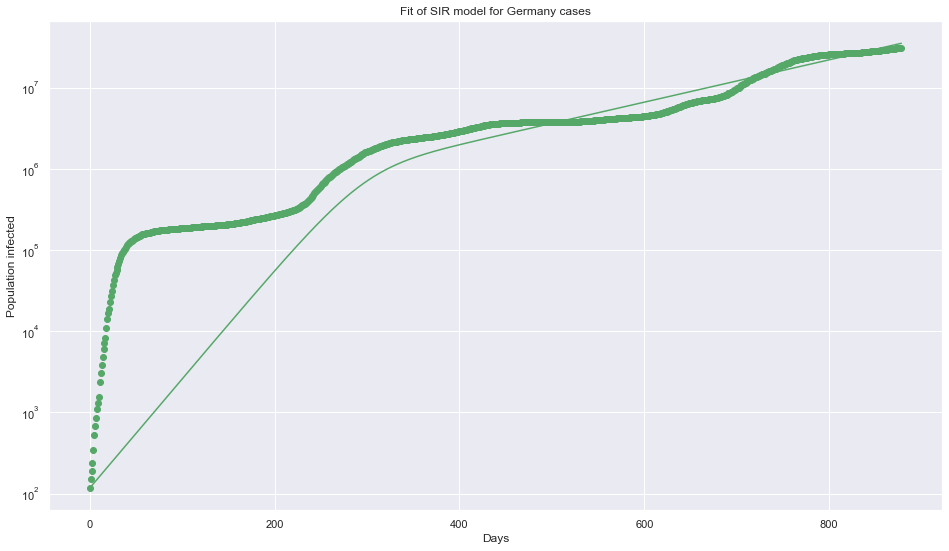

Optimal parameters: beta =  0.02495709468882617 and gamma =  -0.006001423135129758
Basic Reproduction Number R0:  -4.158529423252634


In [32]:
plt.semilogy(t_Germany, ydata_Germany, 'o',color='g')
plt.semilogy(t_Germany, fitted_Germany, color='g')
plt.title('Fit of SIR model for Germany cases')
plt.ylabel('Population infected')
plt.xlabel('Days')
plt.show()
print('Optimal parameters: beta = ', popt_Germany[0], 'and gamma = ', popt_Germany[1])
print('Basic Reproduction Number R0: ',popt_Germany[0]/popt_Germany[1] )

# India

In [33]:
ydata_India = np.array(df_processed.India_infected[70:])
#ydata_India = ydata_India.astype(int)
t_India=np.arange(len(ydata_India))

In [34]:
# Parameters

#N0 = country_population_list[1] # Population size
N0 = 10000000
beta = 0.4
gamma = 0.1  # 1(gamma) Person can infect 4(beta) people

I0 = ydata_India[0]   # Initial infected size
#S0 = N0-I0  # Population prone to infection
S0 = N0-I0
R0 = 0  # Initial recovered size

In [35]:
I0

62.0

In [36]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model, (S0, I0, R0), t_India, args=(beta, gamma))[:,1] # we only would like to get dI

In [37]:
popt=[0.4, 0.1]
fit_odeint(t_India, *popt)

array([ 6.20000000e+01,  8.36909927e+01,  1.12970529e+02,  1.52493319e+02,
        2.05842667e+02,  2.77855210e+02,  3.75059131e+02,  5.06265482e+02,
        6.83365969e+02,  9.22409133e+02,  1.24505170e+03,  1.68051525e+03,
        2.26822311e+03,  3.06135157e+03,  4.13160906e+03,  5.57566055e+03,
        7.52375121e+03,  1.01512590e+04,  1.36941292e+04,  1.84694196e+04,
        2.49025088e+04,  3.35628804e+04,  4.52107260e+04,  6.08568159e+04,
        8.18379145e+04,  1.09909067e+05,  1.47351614e+05,  1.97090652e+05,
        2.62806171e+05,  3.49006249e+05,  4.61006982e+05,  6.04733440e+05,
        7.86227290e+05,  1.01074152e+06,  1.28135955e+06,  1.59724008e+06,
        1.95186997e+06,  2.33201236e+06,  2.71813542e+06,  3.08674822e+06,
        3.41425844e+06,  3.68114312e+06,  3.87499284e+06,  3.99155517e+06,
        4.03384409e+06,  4.01006944e+06,  3.93128327e+06,  3.80937718e+06,
        3.65569506e+06,  3.48025115e+06,  3.29141256e+06,  3.09588192e+06,
        2.89884419e+06,  

In [38]:
popt_India, pcov_India = optimize.curve_fit(fit_odeint, t_India, ydata_India)
perr_India = np.sqrt(np.diag(pcov_India))

C:\Users\DigiBau\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt = -beta*S*I/N0
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt = beta*S*I/N0-gamma*I
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt = gamma*I


In [39]:
print('standard deviation error: ', str(perr_India), 'start infect:', ydata_India[0])
print('Optimal parameters: beta = ', popt_India[0], 'and gamma = ', popt_India[1])

standard deviation error:  [1.68901133e-03 1.95365248e-05] start infect: 62.0
Optimal parameters: beta =  0.07097825660317537 and gamma =  -0.0024212303943521897


In [40]:
fitted_India = fit_odeint(t_India, *popt_India)

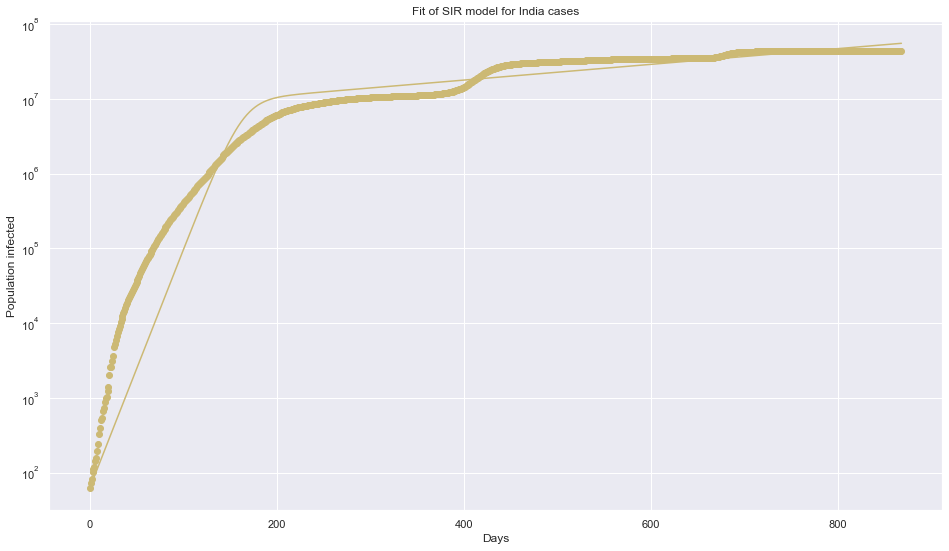

Optimal parameters: beta =  0.07097825660317537 and gamma =  -0.0024212303943521897
Basic Reproduction Number R0:  -29.314953574323482


In [41]:
plt.semilogy(t_India, ydata_India, 'o',color='y')
plt.semilogy(t_India, fitted_India, color='y')
plt.title('Fit of SIR model for India cases')
plt.ylabel('Population infected')
plt.xlabel('Days')
plt.show()
print('Optimal parameters: beta = ', popt_India[0], 'and gamma = ', popt_India[1])
print('Basic Reproduction Number R0: ',popt_India[0]/popt_India[1] )

# Spain

In [42]:
ydata_Spain = np.array(df_processed.Spain_infected[60:])
t_Spain=np.arange(len(ydata_Spain))

In [43]:
# Parameters

#N0 = country_population_list[1] # Population size
N0 = 1000000
beta = 0.4
gamma = 0.1  # 1(gamma) Person can infect 4(beta) people

I0 = ydata_Spain[0]   # Initial infected size
#S0 = N0-I0  # Population prone to infection
S0 = N0-I0
R0 = 0  # Initial recovered size

In [44]:
I0

84.0

In [45]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model, (S0, I0, R0), t_Spain, args=(beta, gamma))[:,1] # we only would like to get dI

In [46]:
popt=[0.4, 0.1]
fit_odeint(t_Spain, *popt)

array([ 8.40000000e+01,  1.13383486e+02,  1.53042619e+02,  2.06568578e+02,
        2.78805714e+02,  3.76287308e+02,  5.07821566e+02,  6.85278620e+02,
        9.24645570e+02,  1.24743737e+03,  1.68257731e+03,  2.26889178e+03,
        3.05839934e+03,  4.12060889e+03,  5.54806800e+03,  7.46340059e+03,
        1.00280082e+04,  1.34524200e+04,  1.80078611e+04,  2.40378155e+04,
        3.19669957e+04,  4.23030097e+04,  5.56231394e+04,  7.25355687e+04,
        9.36028098e+04,  1.19218330e+05,  1.49440062e+05,  1.83809318e+05,
        2.21215257e+05,  2.59884352e+05,  2.97554398e+05,  3.31822770e+05,
        3.60569855e+05,  3.82311938e+05,  3.96371532e+05,  4.02842582e+05,
        4.02410066e+05,  3.96114894e+05,  3.85138187e+05,  3.70642503e+05,
        3.53675978e+05,  3.35127918e+05,  3.15719378e+05,  2.96013953e+05,
        2.76438074e+05,  2.57304132e+05,  2.38832734e+05,  2.21172377e+05,
        2.04415987e+05,  1.88614386e+05,  1.73786999e+05,  1.59930261e+05,
        1.47024112e+05,  

In [47]:
popt_Spain, pcov_Spain = optimize.curve_fit(fit_odeint, t_Spain, ydata_Spain)
perr_Spain = np.sqrt(np.diag(pcov_Spain))

C:\Users\DigiBau\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt = -beta*S*I/N0
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt = beta*S*I/N0-gamma*I
C:\Users\DigiBau\AppData\Local\Temp\ipykernel_8044\2838838603.py:17: RuntimeWarning: invalid value encountered in double_scalars
  dI_dt = beta*S*I/N0-gamma*I


In [48]:
print('standard deviation error: ', str(perr_Spain), 'start infect:', ydata_Spain[0])
print('Optimal parameters: beta = ', popt_Spain[0], 'and gamma = ', popt_Spain[1])

standard deviation error:  [3.10293581e-03 2.49243401e-05] start infect: 84.0
Optimal parameters: beta =  0.0772230381137 and gamma =  -0.0035836348083870258


In [49]:
fitted_Spain = fit_odeint(t_Spain, *popt_Spain)

In [ ]:
plt.semilogy(t_Spain, ydata_Spain, 'o',color='r')
plt.semilogy(t_Spain, fitted_Spain, color='r')
plt.title('Fit of SIR model for Spain cases')
plt.ylabel('Population infected')
plt.xlabel('Days')
plt.show()
print('Optimal parameters: beta = ', popt_Spain[0], 'and gamma = ', popt_Spain[1])
print('Basic Reproduction Number R0: ',popt_Spain[0]/popt_Spain[1] )

## Combining all SIR Data from 3 countries in one data frame

In [ ]:
SIR=pd.DataFrame(t_Germany)

In [ ]:
SIR.rename(columns={0:'date'}, inplace=True)

In [ ]:
SIR['Germany_infected'], SIR['Germany_infected_fitted'] =pd.DataFrame(ydata_Germany), pd.DataFrame(fitted_Germany)

In [ ]:
SIR.head()

In [ ]:
SIR['India_infected'], SIR['India_infected_fitted'] =pd.DataFrame(ydata_India), pd.DataFrame(fitted_India)

In [ ]:
SIR.tail()

In [ ]:
SIR['Spain_infected'], SIR['Spain_infected_fitted'] =pd.DataFrame(ydata_Spain), pd.DataFrame(fitted_Spain)

In [ ]:
SIR.head()

# Dashboard Preparation

In [ ]:
# country drop-down list
country_select_list = []
for each in country_list:
    select = {'label':each, 'value':each+'_infected'}
    country_select_list.append(select)

In [ ]:
country_select_list

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html

fig = go.Figure()
app = dash.Dash()

app.layout = html.Div([
    
    dcc.Markdown('''
    #  Enterprise Data Science - (COVID-19 Data SIR Model)
    '''),



    html.Label(children='Multi-Select Country for visualization'),
    dcc.Dropdown(id='country_drop_down', options=country_select_list, multi=False, value=country_select_list[0]['value'], placeholder='Select the country here...'),
    dcc.Graph(figure=fig, id='main_window_slope') # Output
])

In [ ]:
from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_function(country_drop_down):
    
    traces = []
    
    traces.append(dict(x=SIR.index,
                       y=SIR[country_drop_down],
                         mode='markers',
                         opacity=0.9,
                         line_width=2,
                         marker_size=4,
                         name=country_drop_down))
    traces.append(dict(x=SIR.index,
                       y=SIR[country_drop_down+str('_fitted')],
                         mode='lines',
                         opacity=0.9,
                         line_width=2,
                         marker_size=4,
                         name=country_drop_down+str('_fitted')))
           

    
    return {
            'data': traces,
            'layout': dict(
                width=1280,
                height=720,
                
                xaxis={'title': 'Days',
                        'tickangle':-45,
                        'nticks':20,
                       'tickfont':dict(size=14, color="#7f7f7f"),
                      },
                
                yaxis={'title': 'Infected Population',
                    'type':"linear",
                       'range':'[1.1,5.5]'}
            )}

    

In [ ]:
app.run_server(debug=True, use_reloader=False)

# End